# Extract and Format ERA5

Extract a target region from ERA5 files and process to long format

In [122]:
import pygrib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import os
try:
    os.environ['PROJ_LIB'] = '/home/robwall/anaconda2/envs/metocean_data_py3/share/proj'
    from mpl_toolkits.basemap import Basemap
except:
    os.environ['PROJ_LIB'] = '/home/robwall/anaconda3/envs/py27/share/proj'
    from mpl_toolkits.basemap import Basemap


### Extraction region

In [ ]:
lat_range = [-31, -25]
lon_range = [152, 157]

# Create extended range
extended_lat_range = np.array(lat_range)
extended_lat_range[0] += -2 
extended_lat_range[1] += 2

extended_lon_range = np.array(lon_range)
extended_lon_range[0] += -2 
extended_lon_range[1] += 2



## Load some data

In [ ]:
grb_f = "../data/era5_201707.grib"
sample_grb_f = "../data/era5_20180601.grib"
ww3_f = "../data/nww3.t00z.grib.grib2.grb"

In [ ]:
era = pygrib.open(grb_f)

In [ ]:
sample_era = pygrib.open(sample_grb_f)

In [ ]:
ww3 = pygrib.open(ww3_f)

## View Region

In [ ]:
def plot_aus_waves(grb_f=None, grbs=None, ww3_f=None, grbs_ww3=None):
    if grbs == None:
        grbs = pygrib.open(grb_f)
    grb = grbs.select(name="Significant height of combined wind waves and swell")[0]
    data = grb.values
    lat, lon = grb.latlons()
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    m=Basemap(projection="mill", lat_ts=10, llcrnrlon=140,
         urcrnrlon=165, llcrnrlat=-36, urcrnrlat=-10,
         resolution='c', ax=ax)
    x, y = m(lon, lat)
    cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
    m.drawcoastlines()
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

    # Plot model points
    ax.scatter(x, y, alpha=0.8, s=1, color='k')
        
    # Plot region
    box_lon = [lon_range[0], lon_range[0],
              lon_range[1], lon_range[1],
              lon_range[0]]
    box_lat = [lat_range[0], lat_range[1],
              lat_range[1], lat_range[0],
              lat_range[0]]
    x_box, y_box = m(box_lon, box_lat)
    ax.plot(x_box, y_box, color="green")
    
    # Load ww3
    if grbs_ww3 is None:
        grbs_ww3 = pygrib.open(ww3_f)
    grbs_ww3 = grbs_ww3.select(name="Significant height of combined wind waves and swell")[0]
    ww3lat, ww3lon= grbs_ww3.latlons()
    xww3, yww3 = m(ww3lon, ww3lat)
    ax.scatter(xww3, yww3, s=30, color = "red", marker="x", alpha=0.5)
    
    plt.title(grb_f)
    plt.show()

In [ ]:
plot_aus_waves(grbs=sample_era, grbs_ww3=ww3)

Identify variables

In [123]:
era_vars_short = set([v.shortName for v in sample_era.select()])
era_vars = set([v.name for v in sample_era.select()])

In [124]:
era_vars

{'10 metre U wind component',
 '10 metre V wind component',
 'Mean direction of total swell',
 'Mean direction of wind waves',
 'Mean period of total swell',
 'Mean period of wind waves',
 'Mean wave direction',
 'Mean wave direction of first swell partition',
 'Mean wave direction of second swell partition',
 'Mean wave period',
 'Mean wave period based on first moment for swell',
 'Mean wave period of first swell partition',
 'Mean wave period of second swell partition',
 'Significant height of combined wind waves and swell',
 'Significant height of wind waves'}

In [125]:
era_vars_short

{'10u',
 '10v',
 'mdts',
 'mdww',
 'mpts',
 'mpww',
 'mwd',
 'mwd1',
 'mwd2',
 'mwp',
 'mwp1',
 'mwp2',
 'p1ps',
 'shww',
 'swh'}

In [126]:
sample_grb = sample_era.select(name="Significant height of combined wind waves and swell")
sample_ww3 = ww3.select(name="Significant height of combined wind waves and swell")

In [127]:
sample_grb[0].analDate

datetime.datetime(2018, 6, 1, 0, 0)

Get data and lat, lons within target region

In [128]:
sample_data_region = sample_grb[0].data(lat1=extended_lat_range[0], lat2=extended_lat_range[1],
                                        lon1=extended_lon_range[0], lon2=extended_lon_range[1])
sample_ww3_region = sample_ww3[0].data(lat1=extended_lat_range[0], lat2=extended_lat_range[1],
                                        lon1=extended_lon_range[0], lon2=extended_lon_range[1])

In [129]:
lat, lon = sample_grb[0].latlons()
ww3_lat, ww3_lon = sample_ww3[0].latlons()

### Data extraction

Process:

- Extract data within region
- Interpolate to GFS grid
- Convert to long format

#### 1. Extract region

In [130]:
def slice_latlon(lat, lon, lat_range, lon_range):
    mask = (lat >= lat_range[0]) & (lat <= lat_range[1]) & \
           (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    dim1 = np.any(mask, axis=1).sum()
    dim2 = np.any(mask, axis=0).sum()
    
    lat_extract = lat[mask].reshape(dim1, dim2)
    lon_extract = lon[mask].reshape(dim1, dim2)
    
    return lat_extract, lon_extract

In [131]:
lat_extract, lon_extract = slice_latlon(lat, lon, lat_range, lon_range)
target_lat, target_lon = slice_latlon(ww3_lat, ww3_lon, lat_range, lon_range)

extended_lat_extract, extended_lon_extract = slice_latlon(lat, lon, extended_lat_range, extended_lon_range)
extended_target_lat, extended_target_lon = slice_latlon(ww3_lat, ww3_lon, extended_lat_range, extended_lon_range)

In [132]:
def plot_extract(data, lat, lon, ww3lat, ww3lon, fig=None, ax=None):
    
    if (ax is None) and (fig is None):
        fig, ax = plt.subplots(figsize=(10,10))
    
    m=Basemap(projection="mill", lat_ts=10, llcrnrlon=140,
         urcrnrlon=165, llcrnrlat=-36, urcrnrlat=-10,
         resolution='c', ax=ax)
    x, y = m(lon, lat)
    cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
    m.drawcoastlines()
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

    # Plot model points
    ax.scatter(x, y, alpha=0.8, s=1, color='k')
        
    # Plot region
    box_lon = [lon_range[0], lon_range[0],
              lon_range[1], lon_range[1],
              lon_range[0]]
    box_lat = [lat_range[0], lat_range[1],
              lat_range[1], lat_range[0],
              lat_range[0]]
    x_box, y_box = m(box_lon, box_lat)
    ax.plot(x_box, y_box, color="green")
    
    xww3, yww3 = m(ww3lon, ww3lat)
    ax.scatter(xww3, yww3, s=30, color = "black", marker="x", alpha=0.5)
    
    plt.title(grb_f)
    
    return fig, ax
    

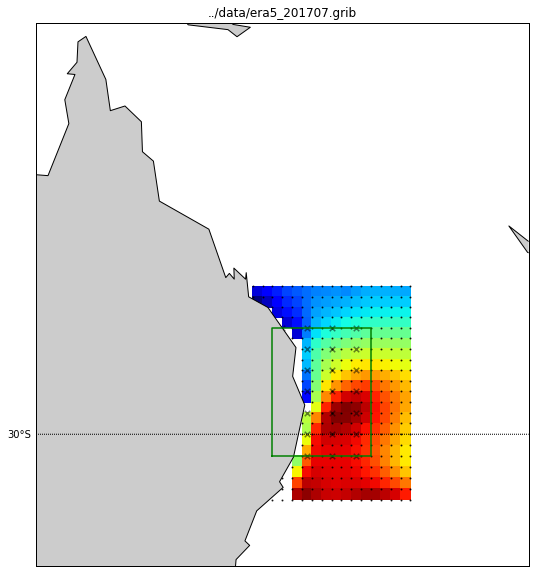

In [133]:
fig, ax = plot_extract(sample_data_region[0], extended_lat_extract, extended_lon_extract, target_lat, target_lon)

In [134]:
target_lat.shape

(7, 4)

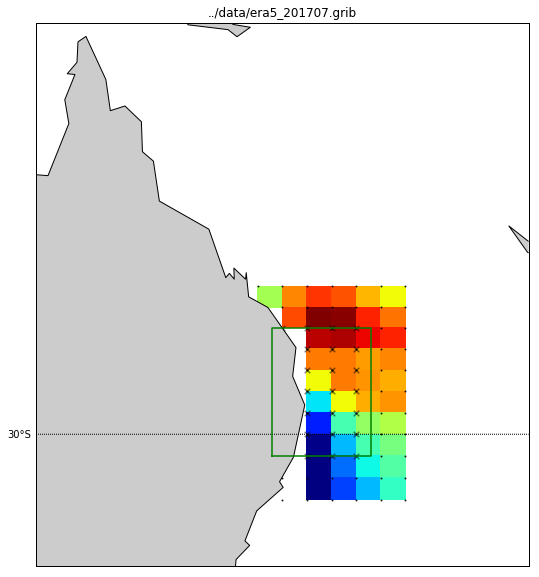

In [135]:
fig, ax = plot_extract(sample_ww3_region[0], extended_target_lat, extended_target_lon, target_lat, target_lon)

#### 2. Interpolate to WW3 grid

In [136]:
def interp_ww3(variable_data, lon, lat, target_lon, target_lat, method='linear'):
    in_values = variable_data[~variable_data.mask].data
    in_lon = lon[~variable_data.mask].flatten()
    in_lat = lat[~variable_data.mask].flatten()
    in_points = np.zeros(shape=(len(in_lon), 2))
    in_points[:,0] = in_lon
    in_points[:,1] = in_lat
    
    interp_data = interpolate.griddata(in_points, in_values, (target_lon, target_lat), method=method)
    
    return interp_data

In [137]:
interp_cubic = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'cubic')
interp_linear = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'linear')
interp_nearest = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'nearest')

sample_data_narrow = sample_grb[0].data(lat1=lat_range[0], lat2=lat_range[1],
                                        lon1=lon_range[0], lon2=lon_range[1])
interp_non_extended_cubic = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'cubic')
interp_non_extended_linear = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'linear')
interp_non_extended_nearest = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'nearest')

Text(0.5, 1.0, 'NN (non-extended)')

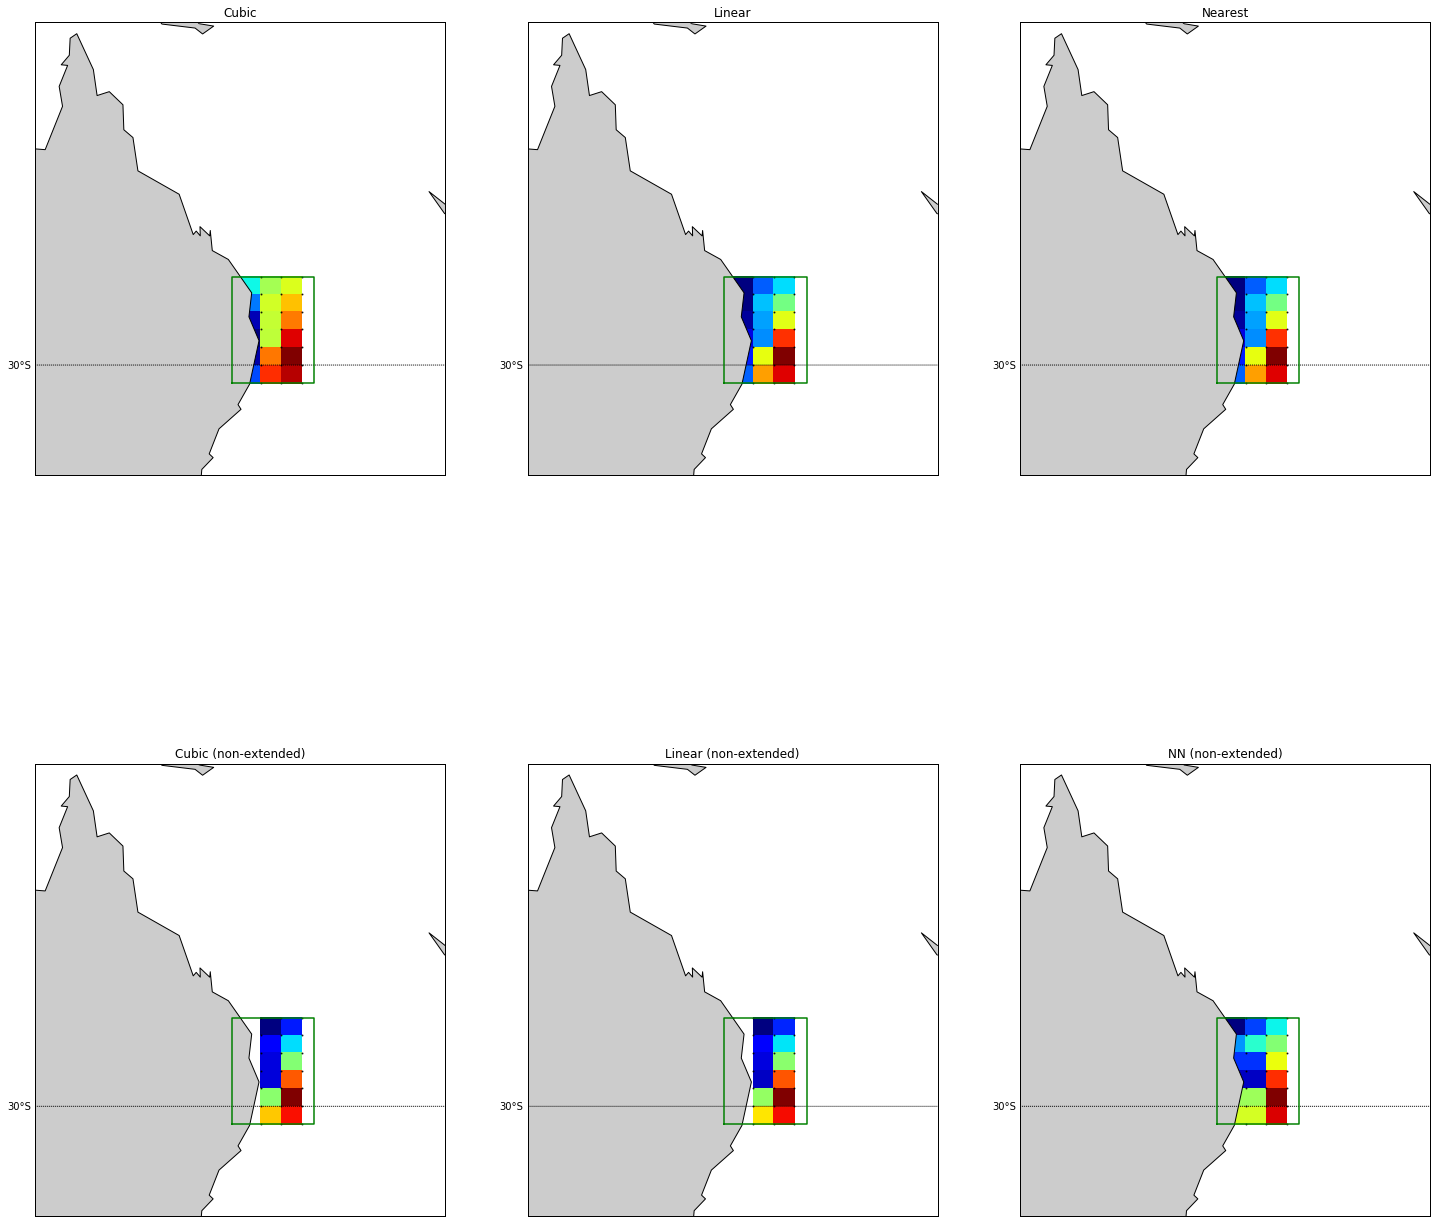

In [138]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,25))

# Cubic
_, _ = plot_extract(interp_cubic, target_lat, target_lon, [0], [0], ax=ax[0,0])
ax[0,0].set_title("Cubic")

# Linear
_, _ = plot_extract(interp_linear, target_lat, target_lon, [0], [0], ax=ax[0,1])
ax[0,1].set_title("Linear")

# Nearest
_, _ = plot_extract(interp_linear, target_lat, target_lon, [0], [0], ax=ax[0,2])
ax[0,2].set_title("Nearest")

# Non-extended cubic
_, _ = plot_extract(interp_non_extended_cubic, target_lat, target_lon, [0], [0], ax=ax[1,0])
ax[1,0].set_title("Cubic (non-extended)")

# Non-extended linear
_, _ = plot_extract(interp_non_extended_linear, target_lat, target_lon, [0], [0], ax=ax[1,1])
ax[1,1].set_title("Linear (non-extended)")

# Non-extended nearest
_, _ = plot_extract(interp_non_extended_nearest, target_lat, target_lon, [0], [0], ax=ax[1,2])
ax[1,2].set_title("NN (non-extended)")

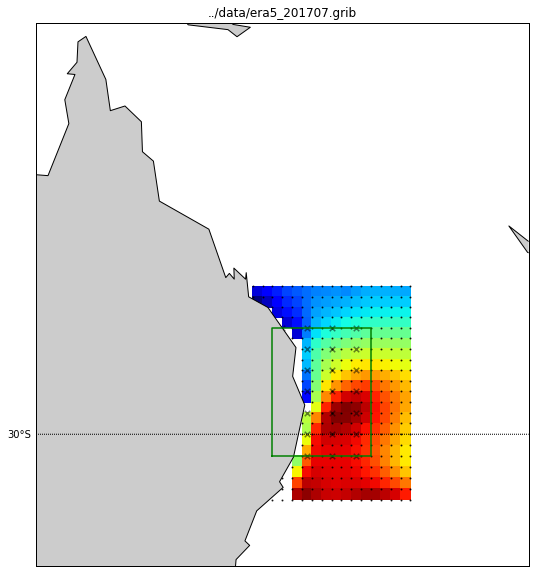

In [139]:
fig, ax = plot_extract(sample_data_region[0], extended_lat_extract, extended_lon_extract, target_lat, target_lon)

NameError: name 'sns' is not defined

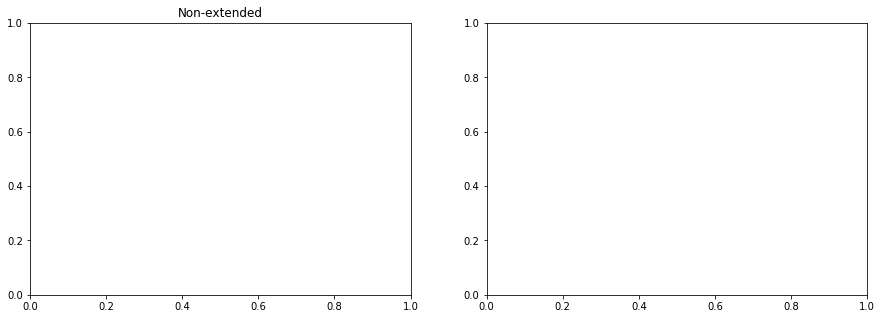

In [140]:
fig ,ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].set_title("Non-extended")
sns.distplot(in_values, ax=ax[0], label="original", color="k",
             hist=False)
sns.distplot(interp_non_extended_linear[~np.isnan(interp_non_extended_linear)], ax=ax[0], label="linear",
             hist=False)
sns.distplot(interp_non_extended_cubic[~np.isnan(interp_non_extended_cubic)], ax=ax[0], label="cubic",
             hist=False)
sns.distplot(interp_non_extended_nearest[~np.isnan(interp_non_extended_nearest)], ax=ax[0], label="nearest",
             hist=False)

ax[1].set_title("Extended")
sns.distplot(in_values, ax=ax[1], label="original", color="k",
             hist=False)
sns.distplot(interp_linear[~np.isnan(interp_linear)], ax=ax[1], label="linear",
             hist=False)
sns.distplot(interp_cubic[~np.isnan(interp_cubic)], ax=ax[1], label="cubic",
             hist=False)
sns.distplot(interp_nearest[~np.isnan(interp_nearest)], ax=ax[1], label="nearest",
             hist=False)
plt.show()

In [ ]:
fig ,ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].set_title("Non-extended")
sns.distplot(in_values, ax=ax[0], label="original", color="k",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_linear[~np.isnan(interp_non_extended_linear)], ax=ax[0], label="linear",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_cubic[~np.isnan(interp_non_extended_cubic)], ax=ax[0], label="cubic",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_nearest[~np.isnan(interp_non_extended_nearest)], ax=ax[0], label="nearest",
             hist=False, kde_kws=dict(cumulative=True))

ax[1].set_title("Extended")
sns.distplot(in_values, ax=ax[1], label="original", color="k",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_linear[~np.isnan(interp_linear)], ax=ax[1], label="linear",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_cubic[~np.isnan(interp_cubic)], ax=ax[1], label="cubic",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_nearest[~np.isnan(interp_nearest)], ax=ax[1], label="nearest",
             hist=False, kde_kws=dict(cumulative=True))
plt.show()

Non-extended cubic or linear seem to be the best downsizing options

#### 3. Convert to long format

In [ ]:
sample_ww3_region_non_extended = sample_ww3[0].data(lat1=lat_range[0], lat2=lat_range[1],
                                        lon1=lon_range[0], lon2=lon_range[1])

In [ ]:
sample_ww3_region_non_extended[0].data

In [ ]:
def interp_to_long(interp_data, mask, var_name, dt):
    interp_data = interp_data[~mask]
    col_names = var_col_names(len(interp_data), var_name)
    #df = pd.DataFrame(data = interp_data, columns=col_names, index=dt)
    df = pd.DataFrame(columns=col_names)
    df.loc[0] = interp_data
    df.index = [dt]
    
    return df
    

In [ ]:
def var_col_names(n, var_name):
    return ["{}_p{}".format(var_name, i) for i in range(1, n+1)]

In [ ]:
str_lat_lon(5, sample_grb[0].shortName)

In [ ]:
df = interp_to_long(interp_non_extended_linear, sample_ww3_region_non_extended[0].mask,
                    sample_grb[0].shortName, sample_grb[0].analDate)
df.head()

In [ ]:
df.index = [sample_grb[0].analDate]

In [ ]:
target_lon.shape

In [ ]:
interp_non_extended_linear

In [ ]:
interp_non_extended_cubic